# All decoders (except KF, NB, and ensemble) run with subsampled neurons

## User Options

Define what folder you're saving to

In [1]:
# save_folder=''
save_folder='/home/jglaser/Files/Neural_Decoding/Results/'

Define what folder you're loading the files from

In [2]:
# load_folder=''
load_folder='/home/jglaser/Data/DecData/'

Define what dataset you are using

In [3]:
dataset='s1'
# dataset='m1'
# dataset='hc'

Define which decoder to run

In [4]:
run_wf=1 #Wiener Filter
run_wc=0 #Wiener Cascade
run_svr=0 #Support vector regression
run_xgb=0 #XGBoost
run_dnn=0 #Feedforward (dense) neural network
run_rnn=0 #Recurrent neural network
run_gru=0 #Gated recurrent units
run_lstm=0 #Long short term memory network

Determine how many neurons you're subsampling, and how many times to do this subsampling

In [5]:
num_nrns_used=10 #Number of neurons you're subsampling

num_folds=10 #Number of times to subsample (Note that we've kept it called "num_folds" from our previous codes, even though this isnt cross validation folds)

## 1. Import Packages

We import standard packages and functions from the accompanying .py files

In [6]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import time
import sys

#Add the main folder to the path, so we have access to the files there.
#Note that if your working directory is not the Paper_code folder, you may need to manually specify the path to the main folder. For example: sys.path.append('/home/jglaser/GitProj/Neural_Decoding')
sys.path.append('..') 

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import metrics
from metrics import get_R2
from metrics import get_rho

#Import decoder functions
from decoders import WienerCascadeDecoder
from decoders import WienerFilterDecoder
from decoders import DenseNNDecoder
from decoders import SimpleRNNDecoder
from decoders import GRUDecoder
from decoders import LSTMDecoder
from decoders import XGBoostDecoder
from decoders import SVRDecoder

#Import Bayesian Optimization package
from bayes_opt import BayesianOptimization

/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 45.0% of memory, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5103, 5110))
/opt/anaconda/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be t

In [7]:
#Turn off deprecation warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 2. Load Data

The data that we load is in the format described below. We have another example script, "Example_format_data" that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [8]:
if dataset=='s1':
    with open(load_folder+'example_data_s1.pickle','rb') as f:
    #     neural_data,vels_binned=pickle.load(f,encoding='latin1')
        neural_data,vels_binned=pickle.load(f)
        
if dataset=='m1':
    with open(load_folder+'example_data_m1.pickle','rb') as f:
    #     neural_data,vels_binned=pickle.load(f,encoding='latin1')
        neural_data,vels_binned=pickle.load(f)
        
if dataset=='hc':
    with open(load_folder+'example_data_hc.pickle','rb') as f:
    #     neural_data,pos_binned=pickle.load(f,encoding='latin1')
        neural_data,pos_binned=pickle.load(f)

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [9]:
if dataset=='s1':
    bins_before=6 #How many bins of neural data prior to the output are used for decoding
    bins_current=1 #Whether to use concurrent time bin of neural data
    bins_after=6 #How many bins of neural data after (and including) the output are used for decoding
    
if dataset=='m1':
    bins_before=13 #How many bins of neural data prior to the output are used for decoding
    bins_current=1 #Whether to use concurrent time bin of neural data
    bins_after=0 #How many bins of neural data after (and including) the output are used for decoding
    
if dataset=='hc':
    bins_before=4 #How many bins of neural data prior to the output are used for decoding
    bins_current=1 #Whether to use concurrent time bin of neural data
    bins_after=5 #How many bins of neural data after (and including) the output are used for decoding

### 3B. Format Covariates

#### Format Input Covariates

In [10]:
#Remove neurons with too few spikes in HC dataset
if dataset=='hc':
    nd_sum=np.nansum(neural_data,axis=0)
    rmv_nrn=np.where(nd_sum<100)
    neural_data=np.delete(neural_data,rmv_nrn,1)

In [11]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

#### Format Output Covariates

In [12]:
#Set decoding output
if dataset=='s1' or dataset=='m1':
    y=vels_binned
if dataset=='hc':
    y=pos_binned

#### In HC dataset, remove time bins with no output (y value)

In [13]:
if dataset=='hc':
    #Remove time bins with no output (y value)
    rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1]))
    X=np.delete(X,rmv_time,0)
    y=np.delete(y,rmv_time,0)

### 3C. Define training/testing/validation sets
We use the same training/testing/validation sets used for the largest training set in Fig. 6

In [14]:
if dataset=='s1' or dataset=='m1':
    dt=.05
if dataset=='hc':
    dt=.2

if dataset=='hc':

    #Size of sets
    test_size=int(450/dt) #7.5 min
    valid_size=test_size #validation size is the same as the test size
    train_size=int(2250/dt) #37.5 min
    
    #End indices
    end_idx=np.int(X.shape[0]*.8) #End of test set
    tr_end_idx=end_idx-test_size-valid_size #End of training set

if dataset=='s1':
    #Size of sets
    test_size=int(300/dt) #5 min
    valid_size=test_size #validation size is the same as the test size
    train_size=int(1200/dt) # 20 min

    #End indices
    end_idx=np.int(X.shape[0]*.9)#End of test set
    tr_end_idx=end_idx-test_size-valid_size #End of training set

if dataset=='m1':
    #Size of sets
    test_size=int(300/dt) #5 min
    valid_size=test_size #validation size is the same as the test size
    train_size=int(600/dt) # 10 min

    #End indices
    end_idx=np.int(X.shape[0]*1)#End of test set
    tr_end_idx=end_idx-test_size-valid_size #End of training set
        
    
#Range of sets
testing_range=[end_idx-test_size,end_idx] #Testing set (length of test_size, goes up until end_idx)
valid_range=[end_idx-test_size-valid_size,end_idx-test_size] #Validation set (length of valid_size, goes up until beginning of test set)
training_range=[tr_end_idx-train_size,tr_end_idx] #Training set (length of train_size, goes up until beginning of validation set)


## 4. Run Decoders

**Initialize lists of results**

In [15]:
#R2 values
mean_r2_wf=np.empty(num_folds)
mean_r2_wc=np.empty(num_folds)
mean_r2_xgb=np.empty(num_folds)
mean_r2_svr=np.empty(num_folds)
mean_r2_dnn=np.empty(num_folds)
mean_r2_rnn=np.empty(num_folds)
mean_r2_gru=np.empty(num_folds)
mean_r2_lstm=np.empty(num_folds)

#Actual data
y_test_all=[]
y_train_all=[]
y_valid_all=[]

#Test predictions
y_pred_wf_all=[]
y_pred_wc_all=[]
y_pred_xgb_all=[]
y_pred_dnn_all=[]
y_pred_rnn_all=[]
y_pred_gru_all=[]
y_pred_lstm_all=[]
y_pred_svr_all=[]

#Training predictions
y_train_pred_wf_all=[]
y_train_pred_wc_all=[]
y_train_pred_xgb_all=[]
y_train_pred_dnn_all=[]
y_train_pred_rnn_all=[]
y_train_pred_gru_all=[]
y_train_pred_lstm_all=[]
y_train_pred_svr_all=[]

#Validation predictions
y_valid_pred_wf_all=[]
y_valid_pred_wc_all=[]
y_valid_pred_xgb_all=[]
y_valid_pred_dnn_all=[]
y_valid_pred_rnn_all=[]
y_valid_pred_gru_all=[]
y_valid_pred_lstm_all=[]
y_valid_pred_svr_all=[]

**In the following section, we**
1. Loop across iterations (each iteration we subsample different neurons)
2. Extract the training/validation/testing data
3. Preprocess the data
4. Run the individual decoders (whichever have been specified in user options). This includes the hyperparameter optimization
5. Save the results

Note that the Wiener Filter, Wiener Cascade, and XGBoost decoders are commented most fully. So look at those for the best understanding.

In [16]:

t1=time.time() #If I want to keep track of how much time has elapsed

num_examples=X.shape[0] #number of examples (rows in the X matrix)


for i in range(num_folds): #Loop through the iterations

    
    #### SUBSAMPLE NEURONS ####
    
    #Randomly subsample "num_nrns_used" neurons
    nrn_idxs=np.random.permutation(X.shape[2])[0:num_nrns_used]
    X_sub=np.copy(X[:,:,nrn_idxs])
    
    # Format for Wiener Filter, Wiener Cascade, SVR, XGBoost, and Dense Neural Network
    #Put in "flat" format, so each "neuron / time" is a single feature
    X_flat_sub=X_sub.reshape(X_sub.shape[0],(X_sub.shape[1]*X_sub.shape[2]))    

    

    ######### SPLIT DATA INTO TRAINING/TESTING/VALIDATION #########
    
    #Note that all sets have a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
    #This makes it so that the different sets don't include overlapping neural data
    
    #Testing set
    testing_set=np.arange(testing_range[0]+bins_before,testing_range[1]-bins_after)

    #Validation set
    valid_set=np.arange(valid_range[0]+bins_before,valid_range[1]-bins_after)

    #Training_set
    training_set=np.arange(training_range[0]+bins_before,training_range[1]-bins_after)  
    
    
    #Get training data
    X_train=X_sub[training_set,:,:]
    X_flat_train=X_flat_sub[training_set,:]
    y_train=y[training_set,:]
    
    #Get testing data
    X_test=X_sub[testing_set,:,:]
    X_flat_test=X_flat_sub[testing_set,:]
    y_test=y[testing_set,:]

    #Get validation data
    X_valid=X_sub[valid_set,:,:]
    X_flat_valid=X_flat_sub[valid_set,:]
    y_valid=y[valid_set,:]


    
    
    ##### PREPROCESS DATA #####
    
    #Z-score "X" inputs. 
    X_train_mean=np.nanmean(X_train,axis=0) #Mean of training data
    X_train_std=np.nanstd(X_train,axis=0) #Stdev of training data
    X_train=(X_train-X_train_mean)/X_train_std #Z-score training data
    X_test=(X_test-X_train_mean)/X_train_std #Preprocess testing data in same manner as training data
    X_valid=(X_valid-X_train_mean)/X_train_std #Preprocess validation data in same manner as training data

    #Z-score "X_flat" inputs. 
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

    #Zero-center outputs
    y_train_mean=np.nanmean(y_train,axis=0) #Mean of training data outputs
    y_train=y_train-y_train_mean #Zero-center training output
    y_test=y_test-y_train_mean #Preprocess testing data in same manner as training data
    y_valid=y_valid-y_train_mean #Preprocess validation data in same manner as training data
    
    #Z-score outputs (for SVR)
    y_train_std=np.nanstd(y_train,axis=0)
    y_zscore_train=y_train/y_train_std
    y_zscore_test=y_test/y_train_std
    y_zscore_valid=y_valid/y_train_std    
    
    
    
    ################# DECODING #################
    
    #Add actual train/valid/test data to lists (for saving)
    y_test_all.append(y_test)
    y_train_all.append(y_train)
    y_valid_all.append(y_valid)


    
    ###### WIENER FILTER ######
    if run_wf:
        #Note - the Wiener Filter has no hyperparameters to fit, unlike all other methods
        
        #Declare model
        model_wf=WienerFilterDecoder()
        #Fit model on training data
        model_wf.fit(X_flat_train,y_train)
        #Get test set predictions
        y_test_predicted_wf=model_wf.predict(X_flat_test)   
        #Get R2 of test set (mean of x and y values of position/velocity)
        mean_r2_wf[i]=np.mean(get_R2(y_test,y_test_predicted_wf))
        #Print R2 values on test set
        R2s_wf=get_R2(y_test,y_test_predicted_wf)
        print('R2s_wf:', R2s_wf)
        
        #Add predictions of training/validation/testing to lists (for saving)
        y_pred_wf_all.append(y_test_predicted_wf)        
        y_train_pred_wf_all.append(model_wf.predict(X_flat_train))
        y_valid_pred_wf_all.append(model_wf.predict(X_flat_valid))        

        
    ###### WIENER CASCADE ######
    if run_wc:
        
        ### Get hyperparameters using Bayesian optimization based on validation set R2 values###
    
        #Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
        #as a function of the hyperparameter we are fitting (here, degree)
        def wc_evaluate(degree):
            model_wc=WienerCascadeDecoder(degree) #Define model
            model_wc.fit(X_flat_train,y_train) #Fit model
            y_valid_predicted_wc=model_wc.predict(X_flat_valid) #Validation set predictions
            return np.mean(get_R2(y_valid,y_valid_predicted_wc)) #R2 value of validation set (mean over x and y position/velocity)
        
        #Do bayesian optimization
        wcBO = BayesianOptimization(wc_evaluate, {'degree': (1, 5.01)}, verbose=0) #Define Bayesian optimization, and set limits of hyperparameters    
        wcBO.maximize(init_points=3, n_iter=3) #Set number of initial runs and subsequent tests, and do the optimization
        best_params=wcBO.res['max']['max_params'] #Get the hyperparameters that give rise to the best fit
        degree=best_params['degree']
#         print("degree=", degree)

        ### Run model w/ above hyperparameters
        
        model_wc=WienerCascadeDecoder(degree) #Declare model
        model_wc.fit(X_flat_train,y_train) #Fit model on training data
        y_test_predicted_wc=model_wc.predict(X_flat_test) #Get test set predictions
        mean_r2_wc[i]=np.mean(get_R2(y_test,y_test_predicted_wc)) #Get test set R2 (mean across x and y position/velocity)
        #Print R2 values on test set
        R2s_wc=get_R2(y_test,y_test_predicted_wc)
        print('R2s_wc:', R2s_wc)
        #Add predictions of training/validation/testing to lists (for saving)
        y_pred_wc_all.append(y_test_predicted_wc)   
        y_train_pred_wc_all.append(model_wc.predict(X_flat_train))
        y_valid_pred_wc_all.append(model_wc.predict(X_flat_valid))

 

    ###### SVR ######
    if run_svr:
        
        ### Get hyperparameters using Bayesian optimization based on validation set R2 values###
        
        #Set the maximum number of iterations (to save time) - 2000 for M1 and S1, 4000 for HC which is faster
        if dataset=='hc':
            max_iter=4000
        else:
            max_iter=2000
        
        #Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
        #as a function of the hyperparameter we are fitting (here, C)
        def svr_evaluate(C):
            model_svr=SVRDecoder(C=C, max_iter=max_iter)
            model_svr.fit(X_flat_train,y_zscore_train) #Note for SVR that we use z-scored y values
            y_valid_predicted_svr=model_svr.predict(X_flat_valid)
            return np.mean(get_R2(y_zscore_valid,y_valid_predicted_svr))
        
        #Do bayesian optimization
        svrBO = BayesianOptimization(svr_evaluate, {'C': (.5, 10)}, verbose=0)    
        svrBO.maximize(init_points=5, n_iter=5)
        best_params=svrBO.res['max']['max_params']
        C=best_params['C']
#         print("C=", C)

        # Run model w/ above hyperparameters
    
        model_svr=SVRDecoder(C=C, max_iter=max_iter)
        model_svr.fit(X_flat_train,y_zscore_train) #Note for SVR that we use z-scored y values
        y_test_predicted_svr=model_svr.predict(X_flat_test)
        mean_r2_svr[i]=np.mean(get_R2(y_zscore_test,y_test_predicted_svr))    
        #Print R2 values on test set
        R2s_svr=get_R2(y_zscore_test,y_test_predicted_svr)
        print('R2s_svr:', R2s_svr)    
        #Add predictions of training/validation/testing to lists (for saving)    
        y_pred_svr_all.append(y_test_predicted_svr)
        y_train_pred_svr_all.append(model_svr.predict(X_flat_train))
        y_valid_pred_svr_all.append(model_svr.predict(X_flat_valid))

        
        
    ##### XGBOOST ######
    if run_xgb:
               
        ### Get hyperparameters using Bayesian optimization based on validation set R2 values###
    
        #Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
        #as a function of the hyperparameter we are fitting (max_depth, num_round, eta)
        def xgb_evaluate(max_depth,num_round,eta):
            max_depth=int(max_depth) #Put in proper format (Bayesian optimization uses floats, and we just want to test the integer)
            num_round=int(num_round) #Put in proper format
            eta=float(eta) #Put in proper format
            model_xgb=XGBoostDecoder(max_depth=max_depth, num_round=num_round, eta=eta) #Define model
            model_xgb.fit(X_flat_train,y_train) #Fit model
            y_valid_predicted_xgb=model_xgb.predict(X_flat_valid) #Get validation set predictions
            return np.mean(get_R2(y_valid,y_valid_predicted_xgb)) #Return mean validation set R2

        #Do bayesian optimization
        xgbBO = BayesianOptimization(xgb_evaluate, {'max_depth': (2, 10.01), 'num_round': (100,700), 'eta': (0, 1)}) #Define Bayesian optimization, and set limits of hyperparameters    
        #Set number of initial runs and subsequent tests, and do the optimization. Also, we set kappa=10 (greater than the default) so there is more exploration when there are more hyperparameters
        xgbBO.maximize(init_points=20, n_iter=20, kappa=10) 
        best_params=xgbBO.res['max']['max_params'] #Get the hyperparameters that give rise to the best fit
        num_round=np.int(best_params['num_round']) #We want the integer value associated with the best "num_round" parameter (which is what the xgb_evaluate function does above)
        max_depth=np.int(best_params['max_depth']) #We want the integer value associated with the best "max_depth" parameter (which is what the xgb_evaluate function does above)
        eta=best_params['eta']
    
        # Run model w/ above hyperparameters
        
        model_xgb=XGBoostDecoder(max_depth=max_depth, num_round=num_round, eta=eta) #Declare model w/ fit hyperparameters
        model_xgb.fit(X_flat_train,y_train) #Fit model
        y_test_predicted_xgb=model_xgb.predict(X_flat_test) #Get test set predictions
        mean_r2_xgb[i]=np.mean(get_R2(y_test,y_test_predicted_xgb)) #Get test set R2 (mean across x and y position/velocity)   
        #Print R2 values on test set
        R2s_xgb=get_R2(y_test,y_test_predicted_xgb)
        print('R2s:', R2s_xgb)
        #Add predictions of training/validation/testing to lists (for saving)        
        y_pred_xgb_all.append(y_test_predicted_xgb)                    
        y_train_pred_xgb_all.append(model_xgb.predict(X_flat_train))
        y_valid_pred_xgb_all.append(model_xgb.predict(X_flat_valid))
        
        
    
    ##### Dense (Feedforward) NN ######
    if run_dnn:
        
        ### Get hyperparameters using Bayesian optimization based on validation set R2 values###
    
        #Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
        #as a function of the hyperparameter we are fitting        
        def dnn_evaluate(num_units,frac_dropout,n_epochs):
            num_units=int(num_units)
            frac_dropout=float(frac_dropout)
            n_epochs=int(n_epochs)
            model_dnn=DenseNNDecoder(units=[num_units,num_units],dropout=frac_dropout,num_epochs=n_epochs)
            model_dnn.fit(X_flat_train,y_train)
            y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)
            return np.mean(get_R2(y_valid,y_valid_predicted_dnn))
        
        #Do bayesian optimization
        dnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 600), 'frac_dropout': (0,.5), 'n_epochs': (2,21)})
        dnnBO.maximize(init_points=20, n_iter=20, kappa=10)
        best_params=dnnBO.res['max']['max_params']
        frac_dropout=float(best_params['frac_dropout'])
        n_epochs=np.int(best_params['n_epochs'])
        num_units=np.int(best_params['num_units'])

        # Run model w/ above hyperparameters
        
        model_dnn=DenseNNDecoder(units=[num_units,num_units],dropout=frac_dropout,num_epochs=n_epochs)
        model_dnn.fit(X_flat_train,y_train)
        y_test_predicted_dnn=model_dnn.predict(X_flat_test)
        mean_r2_dnn[i]=np.mean(get_R2(y_test,y_test_predicted_dnn))    
        #Print R2 values on test set
        R2s_dnn=get_R2(y_test,y_test_predicted_dnn)
        print('R2s:', R2s_dnn)    
        #Add predictions of training/validation/testing to lists (for saving)            
        y_pred_dnn_all.append(y_test_predicted_dnn)
        y_train_pred_dnn_all.append(model_dnn.predict(X_flat_train))
        y_valid_pred_dnn_all.append(model_dnn.predict(X_flat_valid))
        
        
        
    ##### SIMPLE RNN ######
    if run_rnn:
        
        ### Get hyperparameters using Bayesian optimization based on validation set R2 values###
    
        #Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
        #as a function of the hyperparameter we are fitting
        def rnn_evaluate(num_units,frac_dropout,n_epochs):
            num_units=int(num_units)
            frac_dropout=float(frac_dropout)
            n_epochs=int(n_epochs)
            model_rnn=SimpleRNNDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
            model_rnn.fit(X_train,y_train)
            y_valid_predicted_rnn=model_rnn.predict(X_valid)
            return np.mean(get_R2(y_valid,y_valid_predicted_rnn))
        
        #Do bayesian optimization
        rnnBO = BayesianOptimization(rnn_evaluate, {'num_units': (50, 600), 'frac_dropout': (0,.5), 'n_epochs': (2,21)})
        rnnBO.maximize(init_points=20, n_iter=20, kappa=10)
        best_params=rnnBO.res['max']['max_params']
        frac_dropout=float(best_params['frac_dropout'])
        n_epochs=np.int(best_params['n_epochs'])
        num_units=np.int(best_params['num_units'])

        # Run model w/ above hyperparameters
        
        model_rnn=SimpleRNNDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
        model_rnn.fit(X_train,y_train)
        y_test_predicted_rnn=model_rnn.predict(X_test)
        mean_r2_rnn[i]=np.mean(get_R2(y_test,y_test_predicted_rnn))    
        #Print R2 values on test set
        R2s_rnn=get_R2(y_test,y_test_predicted_rnn)
        print('R2s:', R2s_rnn)
        #Add predictions of training/validation/testing to lists (for saving)           
        y_pred_rnn_all.append(y_test_predicted_rnn)
        y_train_pred_rnn_all.append(model_rnn.predict(X_train))
        y_valid_pred_rnn_all.append(model_rnn.predict(X_valid))  
    
    ##### GRU ######
    if run_gru:
        
        ### Get hyperparameters using Bayesian optimization based on validation set R2 values###
    
        #Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
        #as a function of the hyperparameter we are fitting        
        def gru_evaluate(num_units,frac_dropout,n_epochs):
            num_units=int(num_units)
            frac_dropout=float(frac_dropout)
            n_epochs=int(n_epochs)
            model_gru=GRUDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
            model_gru.fit(X_train,y_train)
            y_valid_predicted_gru=model_gru.predict(X_valid)
            return np.mean(get_R2(y_valid,y_valid_predicted_gru))
        
        #Do bayesian optimization
        gruBO = BayesianOptimization(gru_evaluate, {'num_units': (50, 600), 'frac_dropout': (0,.5), 'n_epochs': (2,21)})
        gruBO.maximize(init_points=20, n_iter=20,kappa=10)
        best_params=gruBO.res['max']['max_params']
        frac_dropout=float(best_params['frac_dropout'])
        n_epochs=np.int(best_params['n_epochs'])
        num_units=np.int(best_params['num_units'])

        # Run model w/ above hyperparameters
        
        model_gru=GRUDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
        model_gru.fit(X_train,y_train)
        y_test_predicted_gru=model_gru.predict(X_test)
        mean_r2_gru[i]=np.mean(get_R2(y_test,y_test_predicted_gru))    
        #Print test set R2 values
        R2s_gru=get_R2(y_test,y_test_predicted_gru)
        print('R2s:', R2s_gru)
        #Add predictions of training/validation/testing to lists (for saving)            
        y_pred_gru_all.append(y_test_predicted_gru)
        y_train_pred_gru_all.append(model_gru.predict(X_train))
        y_valid_pred_gru_all.append(model_gru.predict(X_valid))  
    
    
    ##### LSTM ######
    if run_lstm:
        
        ### Get hyperparameters using Bayesian optimization based on validation set R2 values###
    
        #Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
        #as a function of the hyperparameter we are fitting        
        def lstm_evaluate(num_units,frac_dropout,n_epochs):
            num_units=int(num_units)
            frac_dropout=float(frac_dropout)
            n_epochs=int(n_epochs)
            model_lstm=LSTMDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
            model_lstm.fit(X_train,y_train)
            y_valid_predicted_lstm=model_lstm.predict(X_valid)
            return np.mean(get_R2(y_valid,y_valid_predicted_lstm))
        
        #Do bayesian optimization
        lstmBO = BayesianOptimization(lstm_evaluate, {'num_units': (50, 600), 'frac_dropout': (0,.5), 'n_epochs': (2,21)})
        lstmBO.maximize(init_points=20, n_iter=20, kappa=10)
        best_params=lstmBO.res['max']['max_params']
        frac_dropout=float(best_params['frac_dropout'])
        n_epochs=np.int(best_params['n_epochs'])
        num_units=np.int(best_params['num_units'])

        # Run model w/ above hyperparameters
        
        model_lstm=LSTMDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
        model_lstm.fit(X_train,y_train)
        y_test_predicted_lstm=model_lstm.predict(X_test)
        mean_r2_lstm[i]=np.mean(get_R2(y_test,y_test_predicted_lstm))    
        #Print test set R2
        R2s_lstm=get_R2(y_test,y_test_predicted_lstm)
        print('R2s:', R2s_lstm)   
        #Add predictions of training/validation/testing to lists (for saving)        
        y_pred_lstm_all.append(y_test_predicted_lstm)
        y_train_pred_lstm_all.append(model_lstm.predict(X_train))
        y_valid_pred_lstm_all.append(model_lstm.predict(X_valid))    
       
    print ("\n") #Line break after each fold   
    time_elapsed=time.time()-t1 #How much time has passed
    
    
    
    ###### SAVE RESULTS #####
    #Note that I save them after every cross-validation fold rather than at the end in case the code/computer crashes for some reason while running
    
    #Only save results for the decoder we chose to run
    if run_wf:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_wf.pickle','wb') as f:
            pickle.dump([mean_r2_wf,y_pred_wf_all,y_train_pred_wf_all,y_valid_pred_wf_all],f)

    if run_wc:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_wc.pickle','wb') as f:
            pickle.dump([mean_r2_wc,y_pred_wc_all,y_train_pred_wc_all,y_valid_pred_wc_all],f)

    if run_xgb:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_xgb.pickle','wb') as f:
            pickle.dump([mean_r2_xgb,y_pred_xgb_all,y_train_pred_xgb_all,y_valid_pred_xgb_all,time_elapsed],f)

    if run_dnn:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_dnn.pickle','wb') as f:
            pickle.dump([mean_r2_dnn,y_pred_dnn_all,y_train_pred_dnn_all,y_valid_pred_dnn_all,time_elapsed],f)

    if run_rnn:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_rnn.pickle','wb') as f:
            pickle.dump([mean_r2_rnn,y_pred_rnn_all,y_train_pred_rnn_all,y_valid_pred_rnn_all,time_elapsed],f)

    if run_gru:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_gru.pickle','wb') as f:
            pickle.dump([mean_r2_gru,y_pred_gru_all,y_train_pred_gru_all,y_valid_pred_gru_all,time_elapsed],f)

    if run_lstm:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_lstm.pickle','wb') as f:
            pickle.dump([mean_r2_lstm,y_pred_lstm_all,y_train_pred_lstm_all,y_valid_pred_lstm_all,time_elapsed],f)

    if run_svr:
        with open(save_folder+dataset+'_results_nrn'+str(num_nrns_used)+'_svr.pickle','wb') as f:
            pickle.dump([mean_r2_svr,y_pred_svr_all,y_train_pred_svr_all,y_valid_pred_svr_all,time_elapsed],f)
            
            
#Save ground truth results
with open(save_folder+dataset+'_ground_truth_nrns.pickle','wb') as f:
    pickle.dump([y_test_all,y_train_all,y_valid_all],f)
    
print("time_elapsed:",time_elapsed)

('R2s_wf:', array([0.59430535, 0.42842957]))


('R2s_wf:', array([0.49117693, 0.38697557]))


('R2s_wf:', array([0.37827208, 0.37084801]))


('R2s_wf:', array([0.47411434, 0.32976598]))


('R2s_wf:', array([0.44897426, 0.34933761]))


('R2s_wf:', array([0.51197259, 0.4506292 ]))


('R2s_wf:', array([0.36379004, 0.56598965]))


('R2s_wf:', array([0.46641615, 0.53406846]))


('R2s_wf:', array([0.26489115, 0.40835526]))


('R2s_wf:', array([0.53150914, 0.45062675]))


('time_elapsed:', 5.874241828918457)


### Quick check of results

In [17]:
mean_r2_wf

array([0.51136746, 0.43907625, 0.37456005, 0.40194016, 0.39915593,
       0.48130089, 0.46488984, 0.5002423 , 0.33662321, 0.49106795])

In [18]:
np.mean(mean_r2_wf)

0.4400224044705111

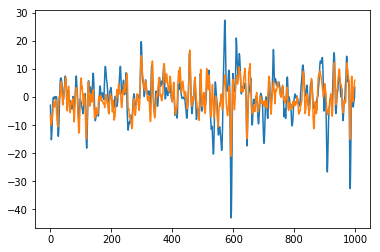

In [19]:
plt.plot(y_test_all[1][0:1000,0])
plt.plot(y_pred_wf_all[1][0:1000,0])